In [11]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.special import eval_chebyt


SIR and Koopman Helper Functions

In [12]:
#SIR model one step at a time
beta = 0.3
gamma = 0.1
h = 0.1

def sir_step(I, R):
    I_next = I + h * (beta * (1 - I - R) * I - gamma * I)
    R_next = R + h * gamma * I
    return I_next, R_next

#discrete time SIR model
def sir_discrete(I0, R0, beta, gamma, h, n_steps):
    I = np.zeros(n_steps)
    R = np.zeros(n_steps)
    
    I[0] = I0
    R[0] = R0
    
    for t in range(1, n_steps):
        I[t] = I[t-1] + h * (beta * (1 - I[t-1] - R[t-1]) * I[t-1] - gamma * I[t-1])
        R[t] = R[t-1] + h * gamma * I[t-1]

    
    return I, R

def  matrix_of_basis_functions(state, degree):
    x = state[0][0]
    y = state[1][0]
    basis = np.zeros((1, (degree + 1)**2))
    #first encode the identity functions
    basis[0, 0] = x
    basis[0, 1] = y
     #then the polynomial basis functions
    for k in range(2, basis.shape[1]):
        i = (k - 2) // (degree + 1)
        j = (k - 2) % (degree + 1)
        basis[0, k] = eval_chebyt(i, x) * eval_chebyt(j, y)
    return basis


#This should be general, not SIR but also in case a linear system
def compute_Krls_RLS(x1_0, x2_0, one_step_forward_func, n_steps, degree, alpha = 1000, lambda_rls = 1.0):
    # Basis size
    n_basis = (degree + 1)**2

    # RLS state for row vector formulation: phi_next = phi @ K_rls
    P = alpha * np.eye(n_basis)
    K_rls = np.zeros((n_basis, n_basis))  # maps: phi (row) -> phi_next (row)

    # Optional: collect batch data for diagnostics (conditioning)
    THETA_Y = np.zeros((1, n_basis))
    THETA_X = np.zeros((1, n_basis))

    # values to record
    K_norm = []
    time_steps = []

    for t in range(n_steps - 1):
        state = np.array([[x1_0], [x2_0]])
        phi = matrix_of_basis_functions(state, degree)  # shape (1, n_basis) - row vector

        I_next, R_next = one_step_forward_func(x1_0, x2_0)
        state_next = np.array([[I_next], [R_next]])
        phi_next = matrix_of_basis_functions(state_next, degree)  # shape (1, n_basis) - row vector

        # keep data for diagnostics
        THETA_Y = np.vstack((THETA_Y, phi_next))
        THETA_X = np.vstack((THETA_X, phi))

        # Multi-output RLS (row vector form): phi_next = phi @ K_rls
        # Update: K <- K + k (y - phi K)
        # where k = (P phi^T) / (lambda + phi P phi^T)
        phi_flat = phi.flatten()            # (n_basis,)
        phi_next_flat = phi_next.flatten()  # (n_basis,)

        denom = (lambda_rls + phi_flat @ P @ phi_flat)
        K_gain = (P @ phi_flat) / denom              # shape (n_basis,)
        error_vec = (phi_next_flat - phi_flat @ K_rls)    # shape (n_basis,)
        K_rls = K_rls + np.outer(K_gain, error_vec)

        P = (P - np.outer(K_gain, phi_flat) @ P) / lambda_rls

        # advance state
        x1_0 = I_next
        x2_0 = R_next

        K_norm.append(np.linalg.norm(K_rls, ord='fro'))
        time_steps.append(t * h)
    return K_rls





Linear System and Threshold Helper Functions

In [13]:
##########################################
G = np.array([[0.5, 0.0], [0.0, 0.25]])
Sigma = np.eye(2) 
############################################
def G_one_step(x1, x2):
    state = np.array([[x1], [x2]])
    next_state = G @ state
    return next_state[0][0], next_state[1][0]
def f_AOI(delta):
    sum = 0
    for i in range(delta): #0 to delta - 1
        G_k = np.linalg.matrix_power(G, i)
        G_k_T = G_k.T
        sum = sum + np.trace(G_k_T @ G_k @ Sigma)
    return sum

def get_sum_to_h(H):
    sum = 0
    for i in range(1, H+1):
        sum = sum + f_AOI(i)
    return sum
def upper_upper_bound(K_rls_no_noise, K_rls_noise, delta):
    return np.sqrt(38) * np.linalg.norm(K_rls_no_noise, ord='fro') **delta +  \
           np.sqrt(38) * np.linalg.norm(K_rls_noise, ord='fro') **delta

def sum_to_h_koopman(H, K_rls_no_noise, K_rls_noise):
    sum = 0
    for i in range(1, H+1):
        sum = sum + upper_upper_bound(K_rls_no_noise, K_rls_noise, i)
    return sum

def gen_sim_data(G, Sigma, n_steps, x_init):
    #Sigma = np.zeros((2,2))
    x1_vals = [x_init[0][0]]
    x2_vals = [x_init[1][0]]
    for i in range(1, n_steps):
        noise = np.random.multivariate_normal(mean=[0,0], cov=Sigma).reshape((2,1))
        x_next = G @ np.array([[x1_vals[-1]], [x2_vals[-1]]]) + noise
        x1_vals.append(x_next[0][0])
        x2_vals.append(x_next[1][0])
    return x1_vals, x2_vals

def moving_time_average(A_pi_tracker, u_indicator_tracker, func):
    n = len(A_pi_tracker)
    time_avg_costs = []
    cumulative_cost = 0
    for k in range(n):
        cumulative_cost += func(int(A_pi_tracker[k])) + u_indicator_tracker[k] * (C + 0)
        time_avg = cumulative_cost / (k + 1)
        time_avg_costs.append(time_avg)
    return time_avg_costs

A RLS and General Simulation Function

In [18]:
def rls_update(P_noisy, base_station_I_vals, base_station_R_vals, k0_list, state, degree, lambda_rls, K_rls_noise):
    # Get previous state (second-to-last in base station arrays)
    state_prev = np.array([[base_station_I_vals[-2]], [base_station_R_vals[-2]]])
    phi_prev = matrix_of_basis_functions(state_prev, degree)  # (1, n_basis)
    
    # Check if data is consecutive
    time_gap = k0_list[-1] - k0_list[-2]
    
    if time_gap == 1:
        # Consecutive: use direct measurement
        phi_predicted = phi_prev
    else:
        # Non-consecutive: predict forward using K_rls_noise
        phi_predicted = phi_prev.copy()
        for _ in range(time_gap):
            phi_predicted = phi_predicted @ K_rls_noise
    
    # Current measurement (just received)
    phi_current = matrix_of_basis_functions(state, degree)
    
    # RLS update for K_rls_noise
    phi_pred_flat = phi_predicted.flatten()  # (n_basis,)
    phi_curr_flat = phi_current.flatten()    # (n_basis,)
    
    denom_noisy = (lambda_rls + phi_pred_flat @ P_noisy @ phi_pred_flat)
    K_gain_noisy = (P_noisy @ phi_pred_flat) / denom_noisy  # (n_basis,)
    error_vec_noisy = (phi_curr_flat - phi_pred_flat @ K_rls_noise)  # (n_basis,)
    K_rls_noise = K_rls_noise + np.outer(K_gain_noisy, error_vec_noisy)
    
    # Covariance update
    P_noisy = (P_noisy - np.outer(K_gain_noisy, phi_pred_flat) @ P_noisy) / lambda_rls
    return K_rls_noise, P_noisy


def run_2D_general_sim(policy, x1_data, x2_data, C, f_AOI_function_type, func, degree, K_rls_no_noise):
    n_steps = len(x1_data)
    K_rls_noise = None
    alpha = 1000
    #For Koopman we need to precompute K_rls from data
    if(f_AOI_function_type == "KOOPMAN"):
        # Basis size
        n_basis = (degree + 1)**2
        n_steps = len(x1_data)
        # RLS state for row vector formulation: phi_next = phi @ K_rls
        P_noisy = alpha * np.eye(n_basis)
        K_rls_noise = np.zeros((n_basis, n_basis))  # Koopman trained on noisy data
        #GETTING RID OF WARMUP
        #use all the data to precompute the noisey koopman from actual system dynamics
        fake_base_station_x1_vals = [x1_data[0]]
        fake_base_station_x2_vals = [x2_data[0]]
        fake_k0_list = [0]
        for i in range(1, 30): #if the norm is too big, it becomes the alternating policy
        #for i in range(1, len(I_actual_vals) - 1):
            fake_base_station_x1_vals.append(x1_data[i])
            fake_base_station_x2_vals.append(x2_data[i])
            fake_k0_list.append(i)
            state = np.array([[x1_data[i]], [x2_data[i]]])
            K_rls_noise, P_noisy = rls_update(P_noisy, fake_base_station_x1_vals, fake_base_station_x2_vals, fake_k0_list, state, degree, lambda_rls, K_rls_noise)
        #precomputing of K hat is complete
        print("Preocomputed K_rls_noise norm: ", np.linalg.norm(K_rls_noise, ord='fro'))

    #calculate threshold:
    threshold_H = n_steps + 1 #because if we dont find one, we wait every time step
    H_max = n_steps
    f_H = 0
    f_H_1 = 0
    this_lam = 0
    for H in range(1, H_max):
        #choose which AOI function to use
        if(f_AOI_function_type == "OPTIMAL"):
            f_H = f_AOI(H)
            f_H_1 = f_AOI(H+1)
            my_sum = get_sum_to_h(H)
            this_lam = (my_sum + C) / H
        elif(f_AOI_function_type == "KOOPMAN"):
            f_H = upper_upper_bound(K_rls_no_noise, K_rls_noise, H)
            f_H_1 = upper_upper_bound(K_rls_no_noise, K_rls_noise, H+1)
            my_sum = sum_to_h_koopman(H, K_rls_no_noise, K_rls_noise)
            this_lam = (my_sum + C) / H
        if(f_H <= this_lam <= f_H_1):
            #found the H this is threshold
            threshold_H = H
            break 
    #have an option where the user chooses a thoreshold
    # if the policy is a number instead of a string, use that as threshold
    if(isinstance(policy, int)): #overrides whatever you found with koopman or optimal (which is for linear)
        threshold_H = policy
    print("Using ", f_AOI_function_type, " policy")
    print("found threshold: ", threshold_H)
    # #assume we send the first data point
    # base_station_x1_vals = [x1_data[0]]
    # base_station_x2_vals = [x2_data[0]]
    base_station_x1_vals = []
    base_station_x2_vals = []
    k0_list = []
    A_pi_tracker = [] #aoi values under policy
    u_indicator_tracker = []  #1 is transmit, 0 if no transmit 
    aoi_flag = False
    #simulation loop
    for k in range(n_steps):
        x1 = x1_data[k]
        x2 = x2_data[k]
        # Calculate AoI cost
        #aoi = f_AOI(G, Sigma, k - k0_list[-1])
        A_k = k - k0_list[-1] + 0 if k0_list else k + 1  # Age since last transmission
        condition = True if (A_k >= threshold_H) else False
        if condition:
            aoi_flag = True
        #if the condition is true, go about it normally 
        #print("A_k: ", A_k)
        if(condition and aoi_flag): #transmission
            #send data
            base_station_x1_vals.append(x1)
            base_station_x2_vals.append(x2)
            k0_list.append(k)
            A_pi_tracker.append(A_k)
            u_indicator_tracker.append(1)
        elif(not condition and aoi_flag):
            #dont send data 
            A_pi_tracker.append(1)
            u_indicator_tracker.append(0)
            aoi_flag = False
        else: 
            #no transmission
            A_pi_tracker.append(A_k)
            u_indicator_tracker.append(0)

    return base_station_x1_vals, base_station_x2_vals, k0_list, A_pi_tracker, u_indicator_tracker, K_rls_noise, K_rls_no_noise


Koopman SIR Verification

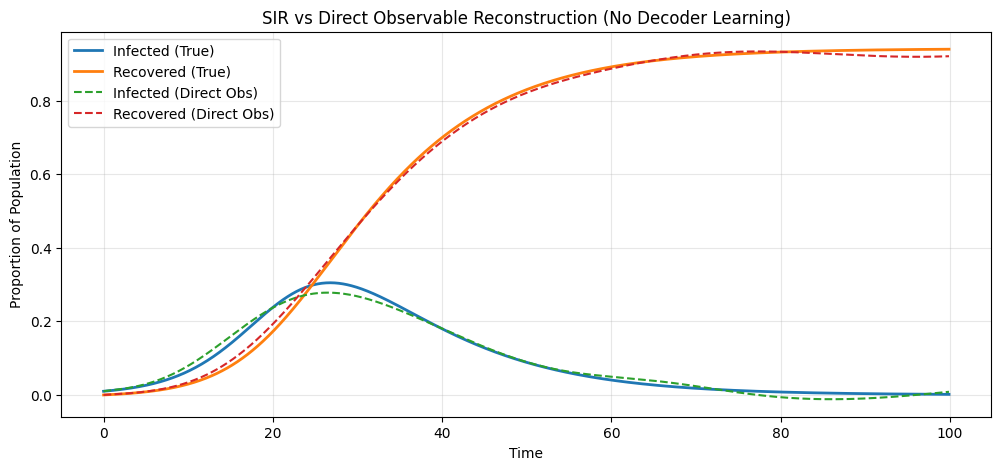

In [15]:
#Make SIR noiseless koopman
I = 0.01
R = 0.0
n_steps = 1000
degree = 5
alpha = 1000.0
lambda_rls = 1.0  
n_basis = (degree + 1)**2
K_rls_SIR = compute_Krls_RLS(I, R, sir_step, n_steps, degree, alpha = 1000, lambda_rls = 1.0)

#NOW TEST IT OUT

# Generate true SIR data for reference
I0 = 0.01
R0 = 0.0
I_data_true = np.zeros(n_steps)
R_data_true = np.zeros(n_steps)
I_data_true[0] = I0
R_data_true[0] = R0
for t in range(n_steps - 1):
    In, Rn = sir_step(I0, R0)
    I0, R0 = In, Rn
    I_data_true[t + 1] = I0
    R_data_true[t + 1] = R0

# Decoder selection matrix B (same as before)
decoder = np.zeros((n_basis, 2))
decoder[0, 0] = 1.0  # I coordinate
decoder[1, 1] = 1.0  # R coordinate

# Initialize reconstruction
I0 = I_data_true[0]
R0 = R_data_true[0]
I_state_recon = np.zeros(n_steps)
R_state_recon = np.zeros(n_steps)
I_state_recon[0] = I0
R_state_recon[0] = R0

# Lift initial state as ROW vector (1 × n_basis)
phi = matrix_of_basis_functions(np.array([[I0], [R0]]), degree)

for t in range(n_steps - 1):
    # Advance in lifted space: φ_{t+1} = φ_t K (row × matrix)
    # K_rls is now trained for row vectors: phi_next = phi @ K_rls
    phi = phi @ K_rls_SIR
    
    # Extract physical state directly: g(x_t) = φ_t B (1×n_basis) @ (n_basis×2) = (1×2)
    x = phi @ decoder
    I_next = float(x[0, 0])
    R_next = float(x[0, 1])
    I_state_recon[t + 1] = I_next
    R_state_recon[t + 1] = R_next

# Plot comparison
time = np.arange(n_steps) * h
plt.figure(figsize=(12, 5))
plt.plot(time, I_data_true, label='Infected (True)', lw=2)
plt.plot(time, R_data_true, label='Recovered (True)', lw=2)
plt.plot(time, I_state_recon, '--', label='Infected (Direct Obs)', lw=1.5)
plt.plot(time, R_state_recon, '--', label='Recovered (Direct Obs)', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Proportion of Population')
plt.legend()
plt.title('SIR vs Direct Observable Reconstruction (No Decoder Learning)')
plt.grid(True, alpha=0.3)
plt.show()

SIR System: Comparison of Optimal and Koopman Policy

Preocomputed K_rls_noise norm:  1.381709336463004
Using  KOOPMAN  policy
found threshold:  4
Preocomputed K_rls_noise norm:  1.381709336463004
Using  KOOPMAN  policy
found threshold:  2
Preocomputed K_rls_noise norm:  1.381709336463004
Using  KOOPMAN  policy
found threshold:  1
Preocomputed K_rls_noise norm:  1.381709336463004
Using  KOOPMAN  policy
found threshold:  2
Preocomputed K_rls_noise norm:  1.381709336463004
Using  KOOPMAN  policy
found threshold:  3
Preocomputed K_rls_noise norm:  1.381709336463004
Using  KOOPMAN  policy
found threshold:  4
Preocomputed K_rls_noise norm:  1.381709336463004
Using  KOOPMAN  policy
found threshold:  5
Preocomputed K_rls_noise norm:  1.381709336463004
Using  KOOPMAN  policy
found threshold:  6
Preocomputed K_rls_noise norm:  1.381709336463004
Using  KOOPMAN  policy
found threshold:  7
Preocomputed K_rls_noise norm:  1.381709336463004
Using  KOOPMAN  policy
found threshold:  8
Preocomputed K_rls_noise norm:  1.381709336463004
Using  KOOPMAN  poli

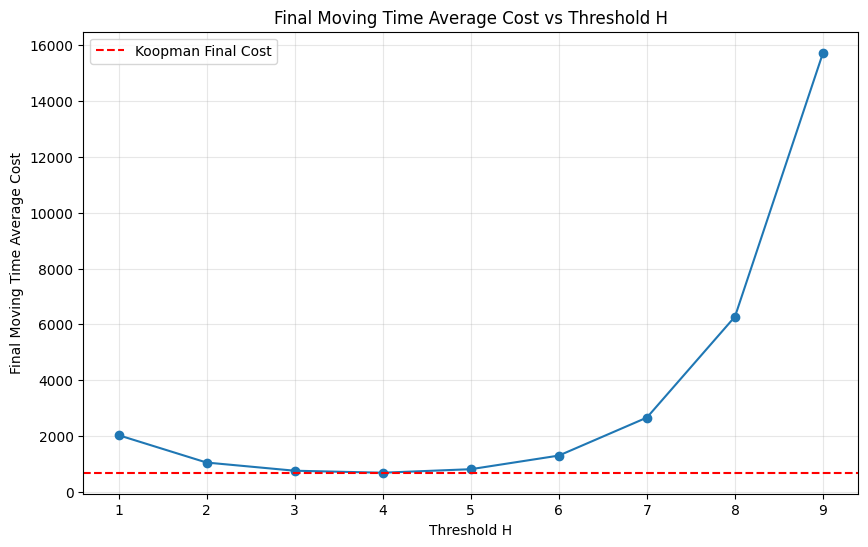

In [ ]:
C = 2000
base_station_x1_vals, base_station_x2_vals, k0_list, A_pi_tracker, u_indicator_tracker, K_rls_noise, K_rls_no_noise = \
    run_2D_general_sim("Threshold", I_data_true, R_data_true, C, f_AOI_function_type="KOOPMAN", func=None, degree=5, K_rls_no_noise=K_rls_SIR)

base_station_x1_vals_2, base_station_x2_vals_2, k0_list_2, A_pi_tracker_2, u_indicator_tracker_2, K_rls_noise_2, K_rls_no_noise_2 = \
    run_2D_general_sim(2, I_data_true, R_data_true, C, f_AOI_function_type="KOOPMAN", func=None, degree=5, K_rls_no_noise=K_rls_SIR)

def koopman_AOI_cost(my_delta):
    return np.sqrt(38) * np.linalg.norm(K_rls_no_noise, ord='fro') **my_delta +  \
           np.sqrt(38) * np.linalg.norm(K_rls_noise, ord='fro') **my_delta

#do a greedy search over the thresholds and find the cheapest one, then plot that against koopman
final_costs = []
for i in range(1, 10):
    base_station_x1_vals_i, base_station_x2_vals_i, k0_list_i, A_pi_tracker_i, u_indicator_tracker_i, K_rls_noise_i, K_rls_no_noise_i = \
    run_2D_general_sim(i, I_data_true, R_data_true, C, f_AOI_function_type="KOOPMAN", func=None, degree=5, K_rls_no_noise=K_rls_SIR)

    #get the moving cost
    time_avg_cost_i = moving_time_average(A_pi_tracker_i, u_indicator_tracker_i, koopman_AOI_cost)
    final_costs.append((i, time_avg_cost_i[-1]))

#get the optimal koopman final cost as well
time_avg_costs_koopman = moving_time_average(A_pi_tracker, u_indicator_tracker, koopman_AOI_cost)
#find what threshold value the koopman one gives (one that has same cost)
koopman_threshold = 0
for i in range(len(final_costs)):
    if(final_costs[i][1] == time_avg_costs_koopman[-1]):
        print("Koopman threshold equivalent: ", final_costs[i][0])
        print("at threshold i = ", i)
        koopman_threshold = i
        break
#plot the cost for different thresholds
thresholds, costs = zip(*final_costs)
plt.figure(figsize=(10,6))
plt.plot(thresholds, costs, marker='o')
#also plot the koopman final cost as a dotted horizontal line
plt.axhline(y=time_avg_costs_koopman[-1], color='r', linestyle='--', label='Koopman Final Cost')
plt.xlabel('Threshold H')
plt.ylabel('Final Moving Time Average Cost')
plt.title('Final Moving Time Average Cost vs Threshold H')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#This is good! It shows the Koopman policy is optimal compared to other threshold policies



Linear System: Comparison of Optimal and Koopman Policy

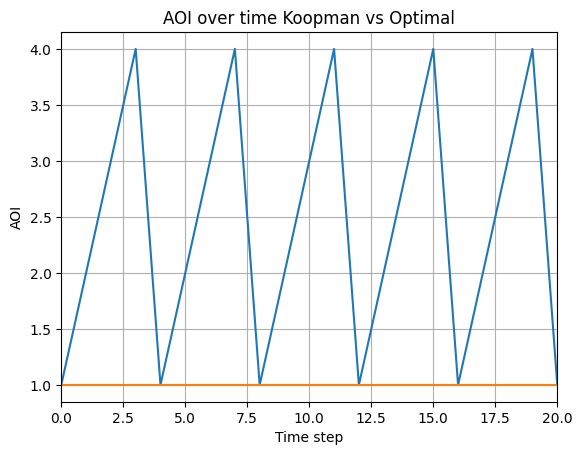

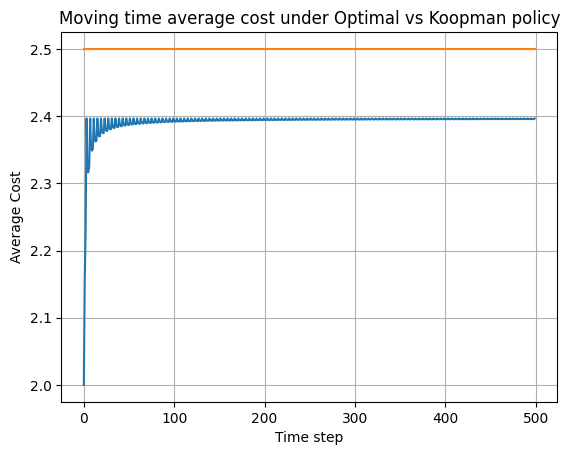

In [17]:
#1. Generate simulation data from linear system with noise 
x_init = np.array([[1], [1]])
n_steps = 500
C = 0.5
x1_data, x2_data = gen_sim_data(G, Sigma, n_steps, x_init)
K_rls = compute_Krls_RLS(x_init[0][0], x_init[1][0], G_one_step, n_steps, degree, alpha = 1000, lambda_rls = 1.0)

#get the optimal policy data first
base_station_x1_vals_o, base_station_x2_vals_o, k0_list_o, A_pi_tracker_o, u_indicator_tracker_o, K_rls_noise_o, K_rls_no_noise_o = \
    run_2D_general_sim("Norm", x1_data, x2_data, C, "OPTIMAL", None, degree, None)

#get the koopman data next
base_station_x1_vals_k, base_station_x2_vals_k, k0_list_k, A_pi_tracker_k, u_indicator_tracker_k, K_rls_noise_k, K_rls_noise_k = \
    run_2D_general_sim("Norm", x1_data, x2_data, C, "KOOPMAN", None, degree, K_rls)
#plot the aoi tracker
plt.figure()
plt.plot(A_pi_tracker_o, label="Optimal")
plt.plot(A_pi_tracker_k, label="Koopman")
plt.title("AOI over time Koopman vs Optimal")
plt.xlabel("Time step")
plt.ylabel("AOI")
plt.xlim([0, 20])
plt.grid()
plt.show()

#plot the average cost (real cost) over time under the two different policies
moving_time_average_o = moving_time_average(A_pi_tracker_o, u_indicator_tracker_o, f_AOI)
moving_time_average_k = moving_time_average(A_pi_tracker_k, u_indicator_tracker_k, f_AOI)
plt.figure()
plt.plot(moving_time_average_o, label="Optimal")
plt.plot(moving_time_average_k, label="Koopman")
plt.title("Moving time average cost under Optimal vs Koopman policy")
plt.xlabel("Time step")
plt.ylabel("Average Cost")
plt.grid()
plt.show()

